In [1]:
import os
import tensorflow as tf
import numpy as np

SEED = 1234
tf.random.set_seed(SEED)


In [2]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=10,
                                        width_shift_range=10,
                                        height_shift_range=10,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1./255)
else:
    train_data_gen = ImageDataGenerator(rescale=1./255)

# Create validation and test ImageDataGenerator objects
valid_data_gen = ImageDataGenerator(rescale=1./255)


In [3]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
# Get current working directory
cwd = os.getcwd()
dataset_dir = os.path.join(cwd, 'data')

# img

# Batch size
bs = 16

# img shape
img_h = 256
img_w = 256

num_classes=3

# Training
training_dir = os.path.join(dataset_dir, 'training')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=bs, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)

# Validation
validation_dir = os.path.join(dataset_dir, 'validation')
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               batch_size=bs, 
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=SEED)



Found 5052 images belonging to 3 classes.
Found 562 images belonging to 3 classes.


In [4]:
# Create Dataset objects
# ----------------------
size = (256, 256)
# Training
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, size), y))
train_dataset = train_dataset.repeat()

# Validation
# ----------
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

valid_dataset = valid_dataset.map(lambda x, y: (tf.image.resize(x, size), y))
valid_dataset = valid_dataset.repeat()



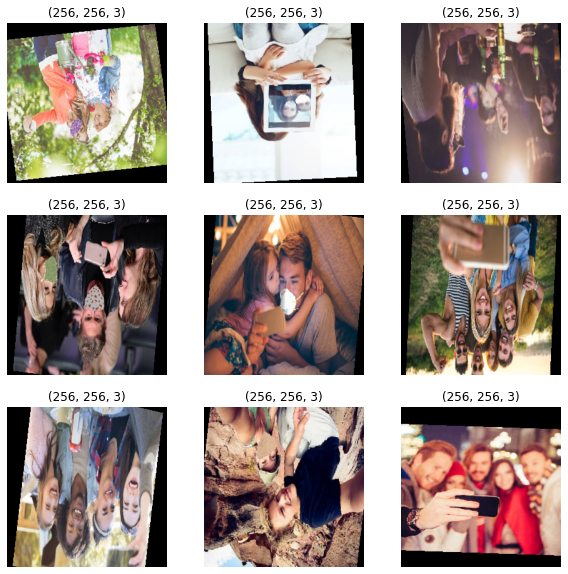

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i])
    plt.title(image[i].shape)
    plt.axis("off")

In [6]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

In [7]:
# Create Model
# ------------

finetuning = True

if finetuning:
    freeze_until = 13 # layer from which we want to fine-tune
    
    for layer in vgg.layers[:freeze_until]:
        layer.trainable = False
else:
    vgg.trainable = False
    
model = tf.keras.Sequential()
model.add(vgg)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=3, activation='softmax'))

# Visualize created model as a table
model.summary()

# Visualize initialized weights
model.weights

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 31,493,955
Trainable params: 26,218,499
Non-trainable params: 5,275,456
_________________________________________________________________


0e-04, -3.09621776e-03, -3.01808352e-03],
          [-2.62522907e-03,  3.51887429e-03, -2.58309790e-03, ...,
           -6.02027494e-03, -8.85035843e-03,  9.85825085e-04]],
 
         [[ 3.02846078e-04,  2.64736195e-03, -1.37099335e-02, ...,
            1.49135189e-02, -4.65666235e-04, -6.84898719e-03],
          [-9.60117579e-03,  5.01031429e-03, -1.13053191e-02, ...,
            8.86707660e-03,  6.21224102e-03,  2.48882570e-03],
          [-1.13499342e-02, -4.72285505e-03, -8.57903156e-03, ...,
           -3.04920389e-03,  9.67197306e-03,  1.90250184e-02],
          ...,
          [-4.48127137e-03,  5.53716440e-03,  4.68912302e-03, ...,
           -4.91005788e-03,  6.40070112e-03, -8.28019064e-03],
          [-6.00830279e-03, -7.51605199e-04,  8.29616503e-04, ...,
            2.07461347e-03,  3.22994636e-03, -1.69727230e-03],
          [-2.81035155e-03,  1.36994272e-02, -2.04460253e-03, ...,
           -5.17683988e-03, -9.04289633e-03, -1.79657899e-03]],
 
         [[ 3.09069827e-03,

In [8]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
callbacks = []

In [9]:
# Tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./tb', histogram_freq=1)
callbacks.append(tensorboard_callback)

In [10]:
# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    callbacks.append(es_callback)

epochs = 50
model.fit(x=train_dataset, epochs=epochs,steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen), 
          callbacks=callbacks)

Epoch 1/50
  1/316 [..............................] - ETA: 0s - loss: 1.5167 - accuracy: 0.3125WARNING:tensorflow:From C:\ProgrammiNoSetup\data_science_python_env\data science\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
316/316 [==============================] - 155s 492ms/step - loss: 0.9261 - accuracy: 0.5034 - val_loss: 0.6593 - val_accuracy: 0.6762
Epoch 2/50
316/316 [==============================] - 148s 470ms/step - loss: 0.6321 - accuracy: 0.6890 - val_loss: 0.5339 - val_accuracy: 0.7509
Epoch 3/50
316/316 [==============================] - 154s 486ms/step - loss: 0.5213 - accuracy: 0.7646 - val_loss: 0.5161 - val_accuracy: 0.7776
Epoch 4/50
316/316 [==============================] - 146s 463ms/step - loss: 0.4684 - accuracy: 0.7967 - val_loss: 0.4828 - val_accuracy: 0.8025
Epoch 5/50
316/316

In [11]:
model.save('tl_saved_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: tl_saved_model\assets


In [12]:
model= tf.keras.models.load_model('tl_saved_model')

In [13]:
import pandas as pd
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')


test_dir = './MaskDataset/test' #os.path.join(dataset_dir, 'test')

images = [f for f in os.listdir(test_dir)]
images = pd.DataFrame(images)
images.rename(columns = {0:'filename'}, inplace = True)
images["class"] = 'test'

test_gen = train_data_gen.flow_from_dataframe(images,
                                               test_dir,
                                               batch_size=bs,
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=SEED)


test_gen.reset()

predictions = model.predict(test_gen, len(test_gen), verbose=1)

results = {}
images = test_gen.filenames
i = 0

for p in predictions:
  prediction = np.argmax(p)
  import ntpath
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1

create_csv(results)

Found 450 validated image filenames belonging to 1 classes.
29/29 [==============================] - 11s 383ms/step
